# Cyber Data Analytics Assignment 1
### Credit Card Fraud Detection
This assignment is divided by three different tasks. These tasks are listed below.

- Visualization Task
- Inbalance Task
- Classification Task

### Preprocessing
First preprocessing steps need to be taken in order to start with a useful dataset.

P.S. Make sure 'fraud_detection_group_43.ipynb' is in the same directory as 'data_for_student_case.csv' otherwise the code will not run. 


In [5]:
import math
import sys
from sklearn import preprocessing
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from yellowbrick.classifier import ClassificationReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

le = preprocessing.LabelEncoder()

# load csv as dataframe
df = pd.read_csv('data_for_student_case.csv')


Now the database can be cleaned. This is done by:
 
- dropping refused transactions since it is unclear whether these are fraudulent
- Pandas is not able to read the current date time format, which therefore needs to be rewritten
- Categories which are labelled as strings need to be labelled as integers in order to process them


In [6]:
# copy frame in order to maintain the original
df_process = df.copy()
# remove refused because it can be either fraudulent as non-fraudulent
df_process = df_process[df['simple_journal']!='Refused']
# change creation date so that it fits the processing standard
df_process['creationdate'] = pd.to_datetime(df_process['creationdate'])
df_process['creationmonth'] = df_process.creationdate.dt.month

# Calculate converted amount of money and set amount to the converted value
def convert_currency(row):
    conversion_dict = {'SEK':0.08766,'MXN':0.04057,'AUD':0.5715,'NZD':0.5327,'GBP':1}
    currency = row['currencycode']
    amount = row['amount']
    return abs(round(amount * conversion_dict[currency])/100)

df_process['amount'] = df_process.apply(lambda x: convert_currency(x),axis=1)
df_process['y'] = df_process['simple_journal'].apply(lambda x: x=='Chargeback')



In [21]:
# Drop non-used variables
attribute_columns = list(set(df_process.columns) - 
                 set([ 'txid','bookingdate', 'txvariantcode', 'simple_journal','creationdate','cardverificationcodesupplied']))
df_process = df_process[attribute_columns]



## Section 1 - Visualization Task 
Now that the data is preprocessed, one could generate visualizations of the data in order to find correlations.


/home/richard/PycharmProjects/cda/venv/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/richard/PycharmProjects/cda/venv/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


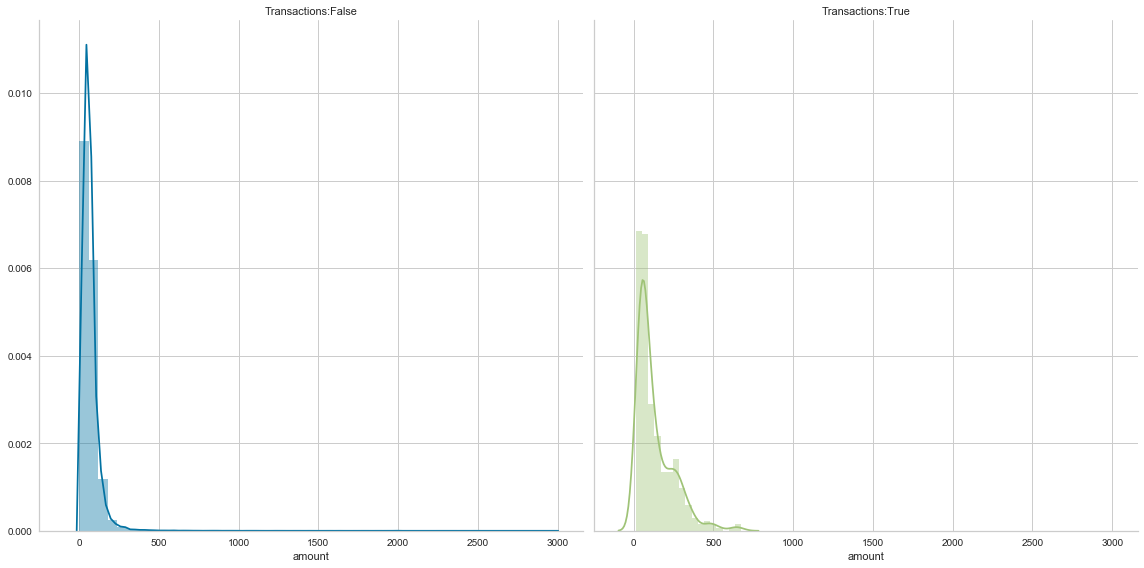

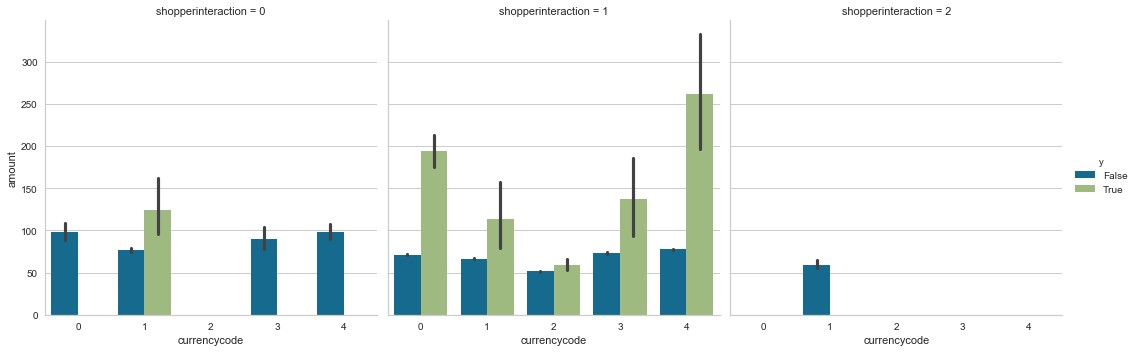

In [14]:
#distplot + factorplot
g = sns.FacetGrid(df_process, col="y", size=8,hue='y')
g.map(sns.distplot,"amount",kde=True)
g.set_titles('Transactions:{col_name}')

sns.factorplot(data=df_process,x="currencycode", y="amount", hue="y",kind='bar',col='shopperinteraction')


In [ ]:
# check which month has the most fraudulent transactions
sns.factorplot(data=df_process,x="creationmonth", y="amount", hue="y",kind='bar',col='shopperinteraction')


## Section 2 - Imbalance Task 
Cyber data does not rely on simple machine learning algorithms. In order to have to highest performance SMOTE has to be applied.
First task is to find out the portion of fraudulent data within this data.


In [22]:
# format all the attributes
df_process['shoppercountrycode'] = le.fit_transform(df_process['shoppercountrycode'].astype(str))
df_process['issuercountrycode'] = le.fit_transform(df_process['issuercountrycode'].astype(str))
df_process['card_id'] = le.fit_transform(df_process['card_id'])
df_process['accountcode'] = le.fit_transform(df_process['accountcode'].astype(str))
df_process['mail_id'] = le.fit_transform(df_process['mail_id'])
df_process['shopperinteraction'] = le.fit_transform(df_process['shopperinteraction'])
df_process['ip_id'] = le.fit_transform(df_process['ip_id'])
df_process['currencycode'] = le.fit_transform(df_process['currencycode'].astype(str))
df_process['bin'] = le.fit_transform(df_process['bin'])



In [23]:
X = np.array(df_process.loc[:, df_process.columns != 'y'])
y = np.array(df_process.loc[:, df_process.columns == 'y'])


## Roc Curves + SMOTE
Now we need to apply SMOTE and checking the performance of the SMOTE by drawing ROC curves.
The paper used: linear regression, random forest and normal linear regression. We are going to apply the same models as the paper. The paper also used GaussianNB as kernel for svc. We are just going to implement regular svc. 


In [6]:
r_forest = RandomForestClassifier(n_estimators=100, n_jobs=2)
lr = LogisticRegression(C=500, penalty='l1')
svc = SVC(gamma='auto')
clf = r_forest


In [24]:

# generate a test set so that SMOTE and ROC function can be applied
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=0)
# apply smote
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))


After OverSampling, the shape of train_X: (331368, 12)
After OverSampling, the shape of train_y: (331368,) 

After OverSampling, counts of label '1': 165684
After OverSampling, counts of label '0': 165684


In [8]:
clf.fit(X_train_res, y_train_res.ravel())


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# parameters = {
#     'C': np.linspace(1, 10, 10)
#              }
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = {
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_res, y_train_res)
# lr = LogisticRegression()
# clf = GridSearchCV(r_forest, parameters, cv=5, verbose=5, n_jobs=3)

# clf.fit(X_train_res, y_train_res.ravel())


NameError: name 'X_train_res' is not defined

In [ ]:
clf.best_params_


In [178]:
lr1 = LogisticRegression(C=7,penalty='l1', verbose=5)
lr1.fit(X_train_res, y_train_res.ravel())


/home/richard/PycharmProjects/cda/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

LogisticRegression(C=7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=5, warm_start=False)

In [167]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Recall metric in the train dataset: 89.6265560165975%


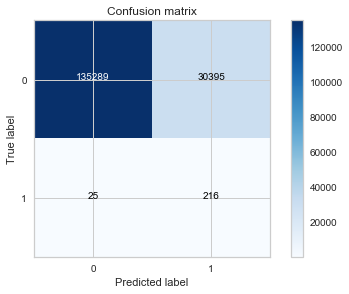

In [179]:
y_train_pre = lr1.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()


In [180]:
tmp = lr1.fit(X_train_res, y_train_res.ravel())


/home/richard/PycharmProjects/cda/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

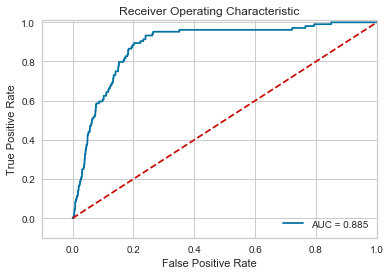

In [181]:
# Roi
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Section 3
First we need to normalize the numerical attribute, in this case amount.


In [ ]:
# For numerical variables, scale them
from sklearn.preprocessing import StandardScaler
df_process['n_amount'] = StandardScaler().fit_transform(df_process['amount'].values.reshape(-1, 1))
# now remove the amount attribute, as we are going to us n_amount from now on
data = df_process.drop(['amount'])
print(df_process.bin.count() )
sum(df_process.ip_id.value_counts()<=10)


## Only thing left is to build the whitebox and the blackbox classifiers.
In order to shuffle the data, the variables need to be changed to arrays


In [ ]:
X = X.values
y = y.values


In [ ]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR



In [4]:
def cross_val_score( X, y):
    scores = []
    best_svr = SVR(kernel='rbf')
    cv = KFold(n_splits=10, random_state=42, shuffle=False)
    for train_index, test_index in cv.split(X):
        print("Train Index: ", train_index, "\n")
        print("Test Index: ", test_index)
    
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        best_svr.fit(X_train, y_train)
        scores.append(best_svr.score(X_test, y_test))
        
cross_val_score(X, y)
    




NameError: name 'X' is not defined